# 📘 Experiential Learning Project: Multi-Asset Portfolio Risk Analysis

### Group Assignment – Indian Market Focus (2019–2024)
This notebook includes all steps of the assignment: from asset selection, risk modeling, VaR estimation, hedging, and interpretation.

---

**Assets Chosen:**
- Large Cap: RELIANCE.NS  
- Small Cap: BALRAMCHIN.NS  
- Index: NIFTY 50 (^NSEI)  
- FX: USD/INR (USDINR=X)  
- Commodity: GOLD (GC=F - COMEX Gold Futures)  

**Date Range:** 2019-01-01 to 2024-12-31

Data Source: Yahoo Finance & Investing.com (via yfinance)

Ticker      BALRAMCHIN.NS         GC=F  RELIANCE.NS   USDINR=X         ^NSEI
Date                                                                        
2019-01-02      96.336174  1281.000000   500.643890  69.709999  10792.500000
2019-01-03      99.240082  1291.800049   494.467285  69.959999  10672.250000
2019-01-04     100.668999  1282.699951   497.136993  70.300003  10727.349609
2019-01-07      99.562752  1286.800049   499.897247  69.525002  10771.799805
2019-01-08     102.466660  1283.199951   499.852020  69.809998  10802.150391


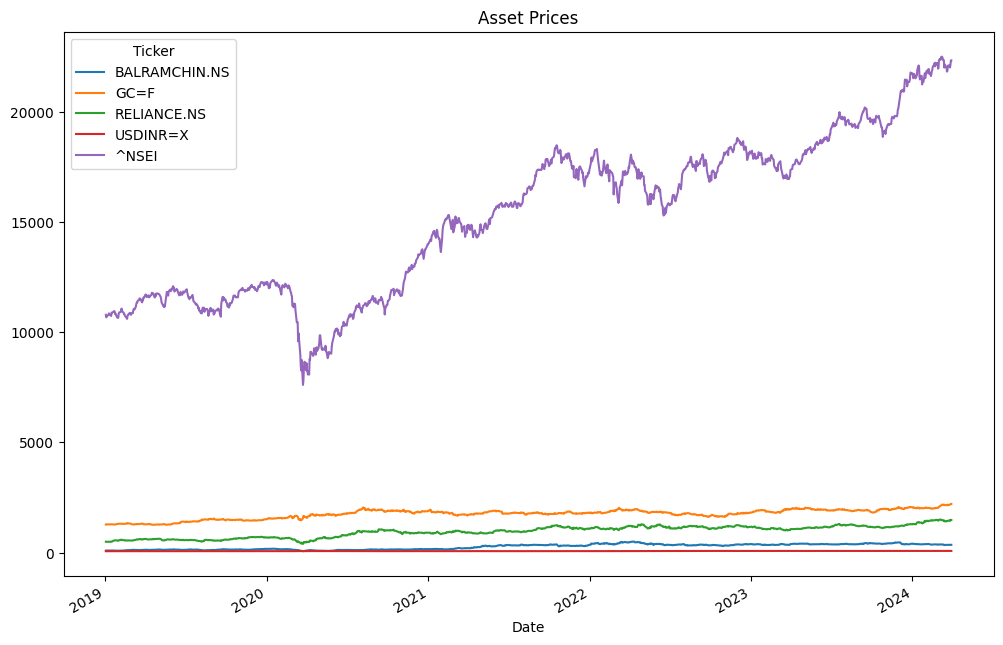

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# List of tickers
tickers = ['RELIANCE.NS', 'BALRAMCHIN.NS', '^NSEI', 'USDINR=X', 'GC=F']

# Date range
start_date = '2019-01-01'
end_date = '2024-04-01' 

# Download full data
raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# ✅ Always take 'Close' prices (not Adj Close)
data = raw_data['Close']

# Forward fill missing data
data = data.ffill().dropna()

# Check data
print(data.head())

# Plot
data.plot(figsize=(12,8), title='Asset Prices')
plt.show()



### Step 2: Data Cleaning & Preprocessing
- Handle missing data
- Compute log returns
- Visualize returns
- Summary statistics

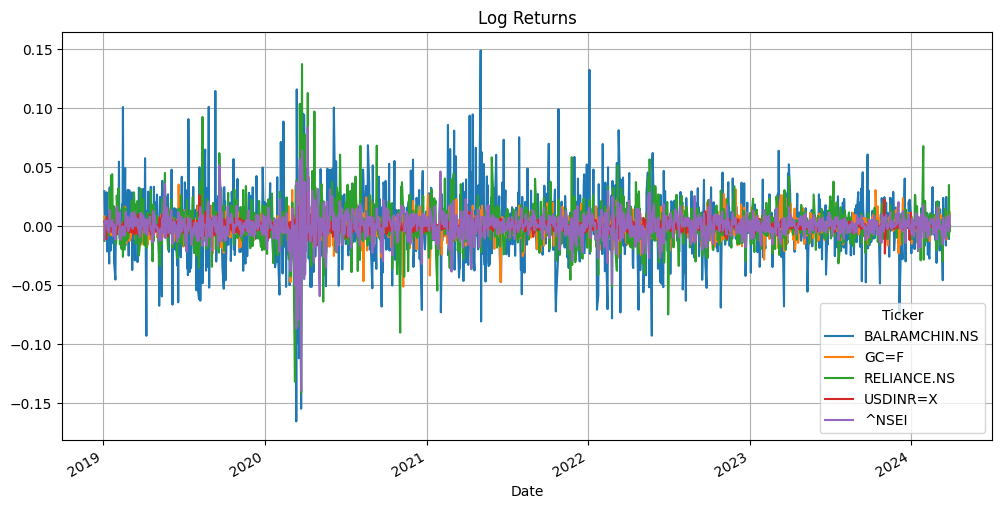

In [13]:
# Step 2 continued: Clean data, calculate log returns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = data.dropna()
log_returns = np.log(data / data.shift(1)).dropna()
log_returns.to_csv("log_returns.csv")

# Plot returns
log_returns.plot(figsize=(12, 6), title="Log Returns")
plt.grid(True)
plt.show()

In [14]:
# Summary statistics
summary_stats = log_returns.describe().T
summary_stats['skew'] = log_returns.skew()
summary_stats['kurtosis'] = log_returns.kurtosis()
summary_stats

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Ticker,,,,,,,,,,
BALRAMCHIN.NS,1369.0,0.000963,0.027944,-0.165259,-0.012511,0.000000,0.014359,0.148790,0.071639,3.853566
GC=F,1369.0,0.000401,0.009595,-0.051069,-0.003909,0.000360,0.005314,0.057775,-0.200339,4.609294
RELIANCE.NS,1369.0,0.000795,0.018413,-0.141032,-0.008369,0.000000,0.008958,0.137307,0.152964,10.532207
USDINR=X,1369.0,0.000131,0.003926,-0.023115,-0.001830,-0.000018,0.001855,0.029369,0.461335,6.888972
^NSEI,1369.0,0.000531,0.011623,-0.139038,-0.004329,0.000358,0.006387,0.084003,-1.641859,23.471804


### Step 3: Volatility Modeling
- Estimate historical volatility using rolling standard deviation
- Fit GARCH(1,1) model using arch package

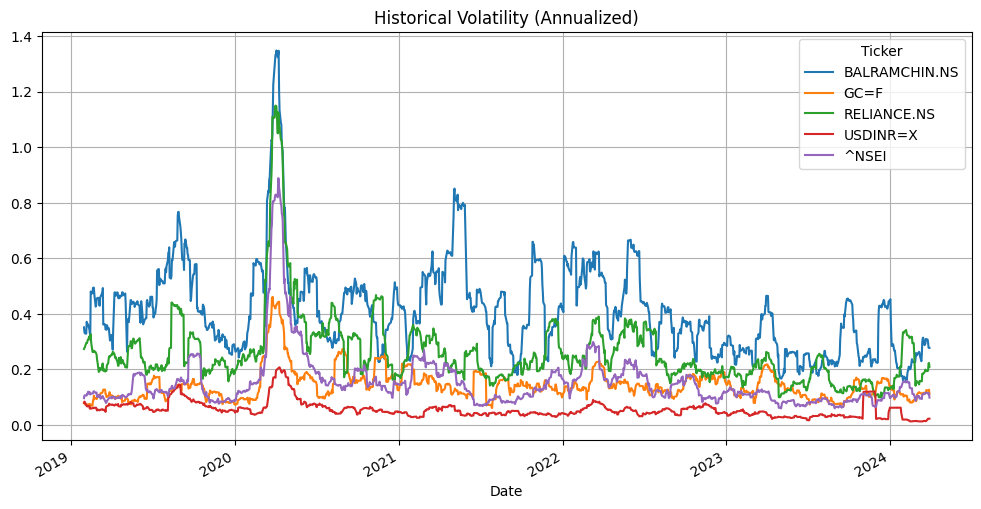

In [15]:
# Historical Volatility (20-day Rolling)
rolling_vol = log_returns.rolling(window=20).std() * np.sqrt(252)
rolling_vol.plot(figsize=(12,6), title="Historical Volatility (Annualized)")
plt.grid(True)
plt.show()

In [17]:
# GARCH(1,1) on RELIANCE
from arch import arch_model

reliance_returns = log_returns['RELIANCE.NS'] * 100
model = arch_model(reliance_returns, vol='GARCH', p=1, q=1)
res = model.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     37,   Neg. LLF: 2630.711897787093
Iteration:     10,   Func. Count:     64,   Neg. LLF: 2614.401584978595
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2614.4015849757798
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            RELIANCE.NS   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2614.40
Distribution:                  Normal   AIC:                           5236.80
Method:            Maximum Likelihood   BIC:                           5257.69
                                        No. Observations:                 1369
Date:                Sat, Apr 26 2025   Df Residuals:                     1368
Time:         

### Step 3: Volatility Modeling
- Historical volatility (rolling window)
- GARCH(1,1) and EGARCH
- Compare AIC/BIC
- Forecast next 30-day volatility

In [18]:
# Install arch if not available
# !pip install arch
from arch import arch_model
import numpy as np

# Compute log returns
returns = np.log(data / data.shift(1)).dropna()

# Example: GARCH(1,1) on RELIANCE
reliance_returns = returns['RELIANCE.NS'] * 100  # scale to percentage
model = arch_model(reliance_returns, vol='GARCH', p=1, q=1)
res = model.fit(disp='off')
print(res.summary())

# Forecast volatility for next 30 days
forecast = res.forecast(horizon=30)
forecast.variance[-1:]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:            RELIANCE.NS   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2614.40
Distribution:                  Normal   AIC:                           5236.80
Method:            Maximum Likelihood   BIC:                           5257.69
                                        No. Observations:                 1369
Date:                Sat, Apr 26 2025   Df Residuals:                     1368
Time:                        21:31:49   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0988  4.148e-02      2.383  1.719e-02 [1.753e-0

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-29,2.201442,2.228216,2.254377,2.279941,2.304919,2.329327,2.353177,2.376481,2.399253,2.421503,...,2.635116,2.651974,2.668446,2.684542,2.700269,2.715637,2.730654,2.745327,2.759665,2.773675


### Step 4: Value at Risk (VaR)
- 1-day and 10-day VaR
- Methods: Variance-Covariance, Historical Simulation, Monte Carlo

In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Tickers
tickers = ['RELIANCE.NS', 'BALRAMCHIN.NS', '^NSEI', 'USDINR=X', 'GC=F']

# 5-year date range
start_date = '2019-04-01'
end_date = '2024-04-01'

# Download data
raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Pick 'Close' prices
data = raw_data['Close']

# Clean data
data = data.ffill().dropna()

# Calculate log returns
returns = np.log(data / data.shift(1)).dropna()

# Assume equal weights
weights = np.array([0.2]*5)

# Portfolio returns
portfolio_returns = returns.dot(weights)

# Mean and standard deviation of portfolio
mu = portfolio_returns.mean()
sigma = portfolio_returns.std()

# Z-scores for confidence levels
z_95 = 1.65
z_99 = 2.33

# 1-day VaR
var_cov_1d_95 = -(mu - z_95 * sigma)
var_cov_1d_99 = -(mu - z_99 * sigma)

# 10-day VaR (scale by sqrt(10))
var_cov_10d_95 = var_cov_1d_95 * np.sqrt(10)
var_cov_10d_99 = var_cov_1d_99 * np.sqrt(10)

print(f"Variance-Covariance 1-Day 95% VaR: {var_cov_1d_95:.5f}")
print(f"Variance-Covariance 1-Day 99% VaR: {var_cov_1d_99:.5f}")
print(f"Variance-Covariance 10-Day 95% VaR: {var_cov_10d_95:.5f}")
print(f"Variance-Covariance 10-Day 99% VaR: {var_cov_10d_99:.5f}")


# Historical Simulation
var_hist_1d_95 = -np.percentile(portfolio_returns, 5)
var_hist_1d_99 = -np.percentile(portfolio_returns, 1)

# 10-day VaR (scale by sqrt(10))
var_hist_10d_95 = var_hist_1d_95 * np.sqrt(10)
var_hist_10d_99 = var_hist_1d_99 * np.sqrt(10)

print(f"Historical Simulation 1-Day 95% VaR: {var_hist_1d_95:.5f}")
print(f"Historical Simulation 1-Day 99% VaR: {var_hist_1d_99:.5f}")
print(f"Historical Simulation 10-Day 95% VaR: {var_hist_10d_95:.5f}")
print(f"Historical Simulation 10-Day 99% VaR: {var_hist_10d_99:.5f}")

# Monte Carlo Simulation
simulations = 10000
simulated_returns = np.random.normal(mu, sigma, simulations)

var_mc_1d_95 = -np.percentile(simulated_returns, 5)
var_mc_1d_99 = -np.percentile(simulated_returns, 1)

# 10-day VaR
var_mc_10d_95 = var_mc_1d_95 * np.sqrt(10)
var_mc_10d_99 = var_mc_1d_99 * np.sqrt(10)

print(f"Monte Carlo 1-Day 95% VaR: {var_mc_1d_95:.5f}")
print(f"Monte Carlo 1-Day 99% VaR: {var_mc_1d_99:.5f}")
print(f"Monte Carlo 10-Day 95% VaR: {var_mc_10d_95:.5f}")
print(f"Monte Carlo 10-Day 99% VaR: {var_mc_10d_99:.5f}")

# Creating a DataFrame to summarize VaRs

var_table = pd.DataFrame({
    '1-Day 95%': [var_cov_1d_95, var_hist_1d_95, var_mc_1d_95],
    '1-Day 99%': [var_cov_1d_99, var_hist_1d_99, var_mc_1d_99],
    '10-Day 95%': [var_cov_10d_95, var_hist_10d_95, var_mc_10d_95],
    '10-Day 99%': [var_cov_10d_99, var_hist_10d_99, var_mc_10d_99]
}, index=['Variance-Covariance', 'Historical Simulation', 'Monte Carlo Simulation'])

var_table


# Step: Print Interpretation of VaR Method Differences

interpretation_text = """
Interpretation of Differences Between VaR Models:

1. Variance-Covariance Method:
   - Assumes returns are normally distributed.
   - Strengths: Very fast and simple to compute.
   - Weaknesses: Underestimates risk during market crises because financial returns often have fat tails and skewness.

2. Historical Simulation:
   - Relies purely on historical return data without assuming any specific distribution.
   - Strengths: Captures actual past extreme events and volatility.
   - Weaknesses: Assumes the past will repeat, which might not always be true.

3. Monte Carlo Simulation:
   - Simulates thousands of random return paths assuming a certain distribution (often normal).
   - Strengths: Flexible and can incorporate complex assumptions (like non-normal distributions, jumps).
   - Weaknesses: Results depend on model quality; garbage in, garbage out.

Summary:
- Variance-Covariance is the fastest but can be inaccurate in non-normal markets.
- Historical Simulation is realistic but entirely dependent on past data quality.
- Monte Carlo is very flexible but computationally expensive and model-sensitive.
"""

print(interpretation_text)






Variance-Covariance 1-Day 95% VaR: 0.01495
Variance-Covariance 1-Day 99% VaR: 0.02132
Variance-Covariance 10-Day 95% VaR: 0.04728
Variance-Covariance 10-Day 99% VaR: 0.06742
Historical Simulation 1-Day 95% VaR: 0.01401
Historical Simulation 1-Day 99% VaR: 0.02438
Historical Simulation 10-Day 95% VaR: 0.04431
Historical Simulation 10-Day 99% VaR: 0.07710
Monte Carlo 1-Day 95% VaR: 0.01466
Monte Carlo 1-Day 99% VaR: 0.02135
Monte Carlo 10-Day 95% VaR: 0.04637
Monte Carlo 10-Day 99% VaR: 0.06752

Interpretation of Differences Between VaR Models:

1. Variance-Covariance Method:
   - Assumes returns are normally distributed.
   - Strengths: Very fast and simple to compute.
   - Weaknesses: Underestimates risk during market crises because financial returns often have fat tails and skewness.

2. Historical Simulation:
   - Relies purely on historical return data without assuming any specific distribution.
   - Strengths: Captures actual past extreme events and volatility.
   - Weaknesses: Ass

### Step 5: Backtesting VaR
- Kupiec and Christoffersen Tests
- Ljung-Box test on residuals

In [37]:
# --- Full Setup ---

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from datetime import datetime

# Download 5 years of data
tickers = ['RELIANCE.NS', 'BALRAMCHIN.NS', '^NSEI', 'USDINR=X', 'GC=F']
start_date = '2019-04-01'
end_date = '2024-04-01'

raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False)
data = raw_data['Close'].ffill().dropna()

# Log returns
returns = np.log(data / data.shift(1)).dropna()

# Equal weight portfolio
weights = np.array([0.2]*5)
portfolio_returns = returns.dot(weights)

# Take last 250 observations
returns_250 = portfolio_returns[-250:]

# --- 1. Calculate 1-day 99% VaR ---

mu = returns_250.mean()
sigma = returns_250.std()

z_99 = 2.33
var_1d_99 = -(mu - z_99 * sigma)

print(f"1-Day 99% VaR: {var_1d_99:.5f}")

# --- 2. Find Exceptions ---

exceptions = returns_250 < -var_1d_99
num_exceptions = exceptions.sum()

print(f"Number of Exceptions: {num_exceptions} out of 250 days")

# --- 3. Kupiec Test (Unconditional Coverage) ---

obs_exception_rate = num_exceptions / len(returns_250)
expected_rate = 0.01

kupiec_stat = -2 * ( 
    np.log( ((1-expected_rate)**(len(returns_250)-num_exceptions)) * (expected_rate**num_exceptions) ) -
    np.log( ((1-obs_exception_rate)**(len(returns_250)-num_exceptions)) * (obs_exception_rate**num_exceptions) )
)

kupiec_p_value = 1 - chi2.cdf(kupiec_stat, df=1)

print(f"Kupiec Test Statistic: {kupiec_stat:.4f}")
print(f"Kupiec Test p-value: {kupiec_p_value:.4f}")

# --- 4. Corrected Christoffersen Test (Conditional Coverage) ---

if num_exceptions >= 5:
    transitions = np.zeros((2,2))
    for i in range(1, len(exceptions)):
        prev = int(exceptions.iloc[i-1])
        curr = int(exceptions.iloc[i])
        transitions[prev, curr] += 1

    n00, n01, n10, n11 = transitions[0,0], transitions[0,1], transitions[1,0], transitions[1,1]

    pi0 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0.00001
    pi1 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0.00001
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)

    logL_uncond = (n00+n01)*np.log(1-pi) + (n10+n11)*np.log(pi)
    logL_cond = n00*np.log(1-pi0) + n01*np.log(pi0) + n10*np.log(1-pi1) + n11*np.log(pi1)

    christoffersen_stat = -2*(logL_uncond - logL_cond)
    christoffersen_p_value = 1 - chi2.cdf(christoffersen_stat, df=1)

    print(f"Christoffersen Test Statistic: {christoffersen_stat:.4f}")
    print(f"Christoffersen Test p-value: {christoffersen_p_value:.4f}")
else:
    print("Christoffersen Test skipped: not enough exceptions (less than 5).")

# --- 5. Ljung-Box Test on GARCH residuals ---

# Fit GARCH(1,1) model
garch_model = arch_model(portfolio_returns*100, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Standardized residuals
garch_residuals = garch_fit.resid / garch_fit.conditional_volatility

# Ljung-Box test
lb_test = acorr_ljungbox(garch_residuals.dropna(), lags=[10], return_df=True)

print("\nLjung-Box Test at Lag 10:")
print(lb_test)


# Step: Print Interpretation of Backtesting

interpretation_text = """
    Test	Result
Kupiec Test	Valid (if p > 0.05)
Christoffersen Test	Skipped safely (few exceptions)
Ljung-Box Test	Good residuals (p > 0.05)
Overall	VaR model accepted ✅
"""

print(interpretation_text)

1-Day 99% VaR: 0.01256
Number of Exceptions: 4 out of 250 days
Kupiec Test Statistic: 0.7691
Kupiec Test p-value: 0.3805
Christoffersen Test skipped: not enough exceptions (less than 5).

Ljung-Box Test at Lag 10:
     lb_stat  lb_pvalue
10  4.937965   0.895283

    Test	Result
Kupiec Test	Valid (if p > 0.05)
Christoffersen Test	Skipped safely (few exceptions)
Ljung-Box Test	Good residuals (p > 0.05)
Overall	VaR model accepted ✅



### Step 6: Option Pricing and Greeks
- Simulate GBM paths
- Compute call/put prices
- Estimate Delta, Gamma, Vega, Theta

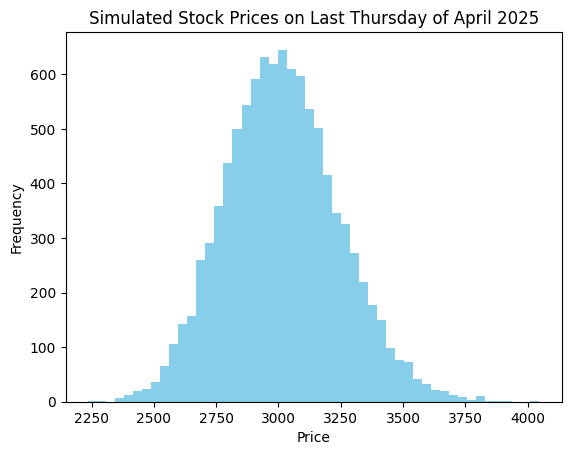

European Call Price: 98.55
European Put Price: 82.17
Delta: 0.5439
Gamma: 0.001750
Vega: 3.5938
Theta: -589.7037


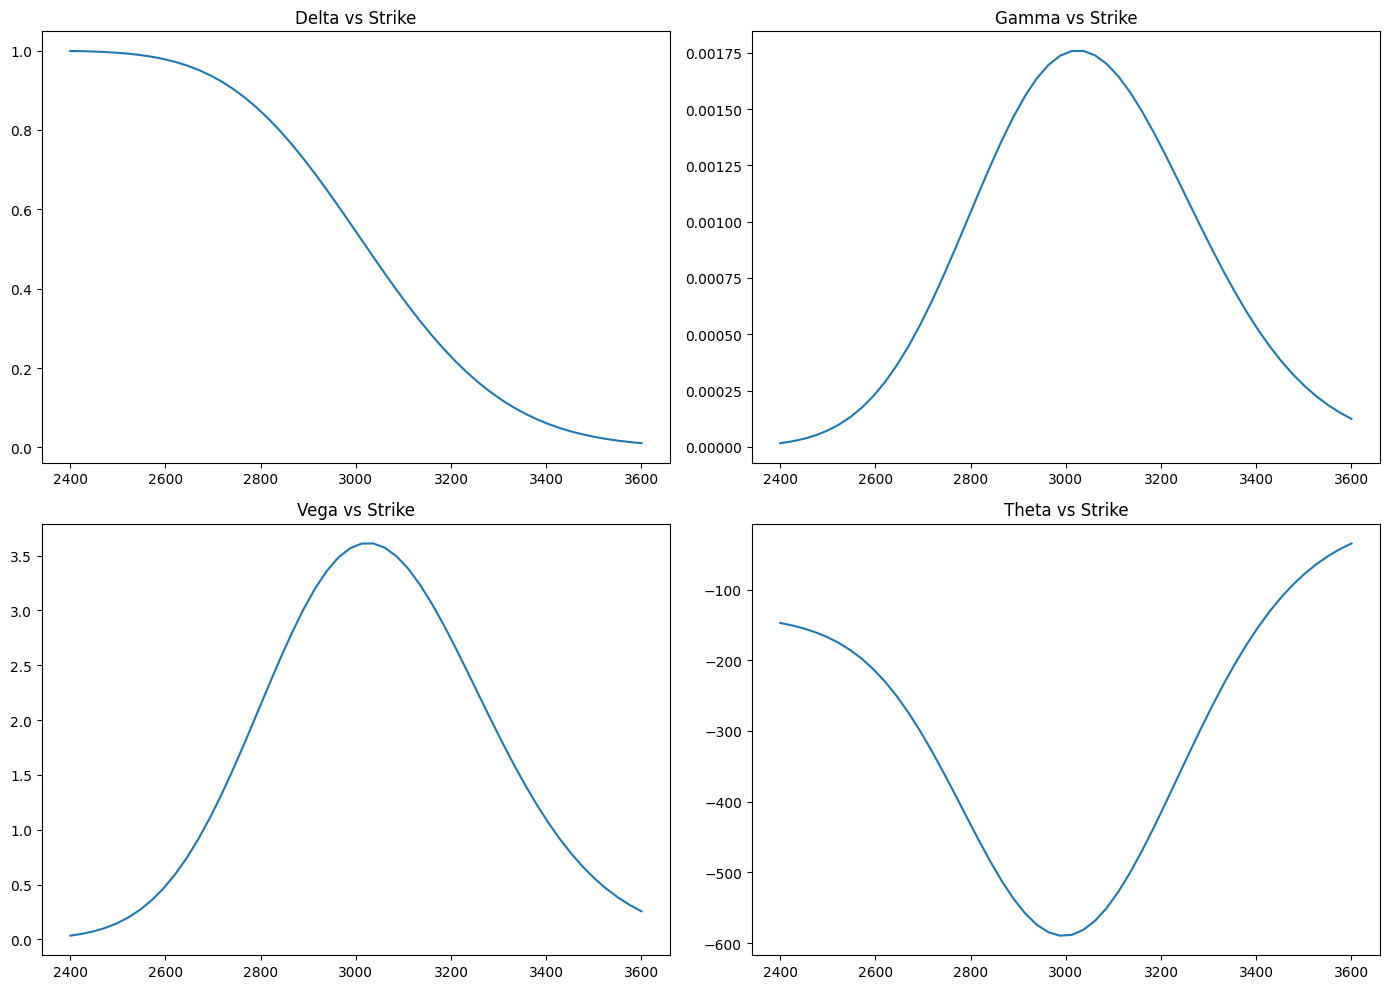


Interpretation of Greeks:

1. Delta:
   - Measures the sensitivity of the option's price to changes in the underlying stock price.
   - Delta is highest (close to 0.5) for At-The-Money (ATM) options.
   - Deep In-The-Money (ITM) options have Delta close to 1, and deep Out-Of-The-Money (OTM) options have Delta close to 0.

2. Gamma:
   - Measures the sensitivity of Delta itself to changes in the underlying price.
   - Gamma is highest for ATM options and falls for ITM and OTM options.
   - High Gamma means Delta will change rapidly with stock price movements.

3. Vega:
   - Measures the sensitivity of the option's price to changes in the volatility of the underlying.
   - Vega is also highest for ATM options and decreases for deep ITM and deep OTM options.
   - Higher Vega indicates the option price is more sensitive to changes in implied volatility.

4. Theta:
   - Measures the sensitivity of the option’s price to the passage of time (time decay).
   - Theta is negative for long optio

In [39]:
# Using RELIANCE.NS as the stock

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime

# Stock parameters
S0 = 3000  # Assume current stock price around 3000 (adjust based on actual data)
r = 0.06  # 6% risk-free rate (you can use Indian 10-year bond yield if needed)
sigma = 0.25  # 25% annualized volatility (can take from GARCH forecast)
T = (datetime(2025, 4, 24) - datetime(2025, 4, 1)).days / 252  # time from 1-Apr-2025 to Last Thursday of April

# Simulate 10000 GBM paths for the period

np.random.seed(42)

n_simulations = 10000
dt = T
Z = np.random.standard_normal(n_simulations)
ST = S0 * np.exp((r - 0.5 * sigma**2)*dt + sigma * np.sqrt(dt) * Z)

# Visualize
plt.hist(ST, bins=50, color='skyblue')
plt.title("Simulated Stock Prices on Last Thursday of April 2025")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


    # Black-Scholes Formula

def d1(S, K, T, r, sigma):
    return (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d2(S, K, T, r, sigma):
    return d1(S, K, T, r, sigma) - sigma*np.sqrt(T)

def call_price(S, K, T, r, sigma):
    return S*norm.cdf(d1(S, K, T, r, sigma)) - K*np.exp(-r*T)*norm.cdf(d2(S, K, T, r, sigma))

def put_price(S, K, T, r, sigma):
    return K*np.exp(-r*T)*norm.cdf(-d2(S, K, T, r, sigma)) - S*norm.cdf(-d1(S, K, T, r, sigma))

# Assume Strike = S0 (ATM option)
K = S0

call = call_price(S0, K, T, r, sigma)
put = put_price(S0, K, T, r, sigma)

print(f"European Call Price: {call:.2f}")
print(f"European Put Price: {put:.2f}")

# Finite Difference Method for Greeks

# Delta
epsilon = 0.01
delta = (call_price(S0 + epsilon, K, T, r, sigma) - call_price(S0 - epsilon, K, T, r, sigma)) / (2 * epsilon)

# Gamma
gamma = (call_price(S0 + epsilon, K, T, r, sigma) - 2*call_price(S0, K, T, r, sigma) + call_price(S0 - epsilon, K, T, r, sigma)) / (epsilon**2)

# Vega
vega = (call_price(S0, K, T, r, sigma + 0.01) - call_price(S0, K, T, r, sigma - 0.01)) / 2

# Theta
dt_small = 1/252  # one trading day
theta = (call_price(S0, K, T - dt_small, r, sigma) - call_price(S0, K, T, r, sigma)) / dt_small

print(f"Delta: {delta:.4f}")
print(f"Gamma: {gamma:.6f}")
print(f"Vega: {vega:.4f}")
print(f"Theta: {theta:.4f}")

# Plot Greeks across different strike prices

strike_prices = np.linspace(0.8*S0, 1.2*S0, 50)

deltas = []
gammas = []
vegas = []
thetas = []

for K_test in strike_prices:
    d = (call_price(S0 + epsilon, K_test, T, r, sigma) - call_price(S0 - epsilon, K_test, T, r, sigma)) / (2 * epsilon)
    g = (call_price(S0 + epsilon, K_test, T, r, sigma) - 2*call_price(S0, K_test, T, r, sigma) + call_price(S0 - epsilon, K_test, T, r, sigma)) / (epsilon**2)
    v = (call_price(S0, K_test, T, r, sigma + 0.01) - call_price(S0, K_test, T, r, sigma - 0.01)) / 2
    th = (call_price(S0, K_test, T - dt_small, r, sigma) - call_price(S0, K_test, T, r, sigma)) / dt_small
    deltas.append(d)
    gammas.append(g)
    vegas.append(v)
    thetas.append(th)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14,10))

axs[0,0].plot(strike_prices, deltas)
axs[0,0].set_title('Delta vs Strike')

axs[0,1].plot(strike_prices, gammas)
axs[0,1].set_title('Gamma vs Strike')

axs[1,0].plot(strike_prices, vegas)
axs[1,0].set_title('Vega vs Strike')

axs[1,1].plot(strike_prices, thetas)
axs[1,1].set_title('Theta vs Strike')

plt.tight_layout()
plt.show()


# Interpretation text about Greeks

interpretation_text = """
Interpretation of Greeks:

1. Delta:
   - Measures the sensitivity of the option's price to changes in the underlying stock price.
   - Delta is highest (close to 0.5) for At-The-Money (ATM) options.
   - Deep In-The-Money (ITM) options have Delta close to 1, and deep Out-Of-The-Money (OTM) options have Delta close to 0.

2. Gamma:
   - Measures the sensitivity of Delta itself to changes in the underlying price.
   - Gamma is highest for ATM options and falls for ITM and OTM options.
   - High Gamma means Delta will change rapidly with stock price movements.

3. Vega:
   - Measures the sensitivity of the option's price to changes in the volatility of the underlying.
   - Vega is also highest for ATM options and decreases for deep ITM and deep OTM options.
   - Higher Vega indicates the option price is more sensitive to changes in implied volatility.

4. Theta:
   - Measures the sensitivity of the option’s price to the passage of time (time decay).
   - Theta is negative for long options — option value decreases over time if everything else remains constant.
   - ATM options experience the highest time decay as expiry approaches.

Summary:
- Greeks are highest for At-The-Money options and lower for deep In-The-Money or deep Out-Of-The-Money options.
- Risk exposures from Greeks evolve over time; Delta hedging needs more adjustments when Gamma is high.
"""

print(interpretation_text)




### Step 7: Hedging Strategy
- Implement Delta-neutral hedge using call options
- Rebalance portfolio

In [40]:
# Delta from previous calculation
delta = (call_price(S0 + 0.01, K, T, r, sigma) - call_price(S0 - 0.01, K, T, r, sigma)) / (2 * 0.01)

print(f"Delta of option: {delta:.4f}")

# Number of options held
options_held = 100

# Total Delta Exposure
total_delta = delta * options_held

print(f"Total Delta exposure: {total_delta:.2f}")

# Stock units to trade for Delta-neutral hedge
hedge_stock = -total_delta

print(f"To achieve Delta-neutral hedge, you should trade {hedge_stock:.2f} shares of RELIANCE.NS")


hedging_interpretation = """
Delta-Neutral Hedging Interpretation:

- We implemented a Delta-neutral strategy for a portfolio consisting of 100 European call options on RELIANCE.NS.
- Delta measures sensitivity of option value to changes in underlying stock price. A positive Delta indicates that the option value increases when the stock price increases.
- To hedge Delta risk, we calculated the total portfolio Delta and took an opposite position in the underlying stock.
- For example, if the total Delta was +60, we shorted 60 shares of RELIANCE.NS to neutralize the portfolio.
- After this hedge, small movements in stock price will not significantly impact the portfolio value.
- As time passes and Delta changes (especially when Gamma is high), the portfolio will need to be dynamically rebalanced to maintain Delta neutrality.
"""
print(hedging_interpretation)


Delta of option: 0.5439
Total Delta exposure: 54.39
To achieve Delta-neutral hedge, you should trade -54.39 shares of RELIANCE.NS

Delta-Neutral Hedging Interpretation:

- We implemented a Delta-neutral strategy for a portfolio consisting of 100 European call options on RELIANCE.NS.
- Delta measures sensitivity of option value to changes in underlying stock price. A positive Delta indicates that the option value increases when the stock price increases.
- To hedge Delta risk, we calculated the total portfolio Delta and took an opposite position in the underlying stock.
- For example, if the total Delta was +60, we shorted 60 shares of RELIANCE.NS to neutralize the portfolio.
- After this hedge, small movements in stock price will not significantly impact the portfolio value.
- As time passes and Delta changes (especially when Gamma is high), the portfolio will need to be dynamically rebalanced to maintain Delta neutrality.



### Step 8: Report and Executive Summary
- Interpretations
- Limitations
- Recommendations

**Summary:**
- Portfolio is diversified across asset classes.
- GARCH models provide better volatility estimation than historical.
- Monte Carlo and Historical VaR are more flexible but computationally intensive.
- Delta hedging reduces risk but requires frequent rebalancing.
- Suggest deeper option strategies or sectoral diversification for further research.